In [1]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID as model
reload(model)

<module 'read_model_ID' from '../code_general/read_model_ID.pyc'>

In [13]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44' 

filename = 'fit_13_6_2019_sim_2.txt'
path = '../fits_Stijn/13_6_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
parameters = np.array(final_par.values)

model_ID,_,parameters,_ = model.combined_model(parameters,model_ID)

Text(29.125,0.5,'Cleavage rate (Hz) time points')

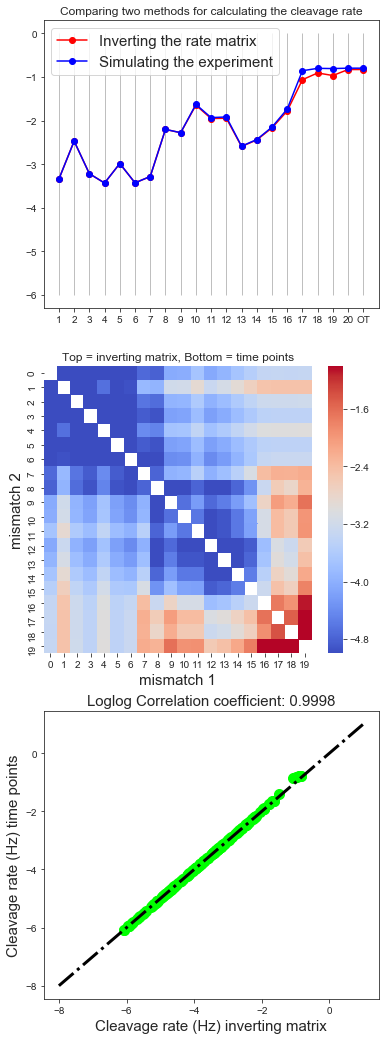

In [21]:
reload(clv)
k_fast = np.zeros(21)
k_slow = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    k_fast[i-1] = np.log10(clv.calc_clv_rate_fast(parameters,model_ID,mismatch_positions))
    k_slow[i-1] = np.log10(clv.calc_clv_rate(parameters,model_ID,mismatch_positions))
k_fast[-1] = np.log10(clv.calc_clv_rate_fast(parameters,model_ID,[]))
k_slow[-1] = np.log10(clv.calc_clv_rate(parameters,model_ID,[]))

f,ax = plt.subplots(3,1,sharey=False,figsize=[6,18])
    
ax[0].plot(range(1,22),k_fast,marker='o',color='red')
ax[0].plot(range(1,22),k_slow,marker='o',color='blue')
ax[0].set_xticks(range(1,22));
ax[0].set_xticklabels(range(1,21)+['OT'])
ax[0].vlines(range(1,22),-6,0,linewidth=0.5,color='grey')
ax[0].legend(['Inverting the rate matrix','Simulating the experiment'],fontsize=15)
ax[0].set_title('Comparing two methods for calculating the cleavage rate')

k_dmm = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_dmm[i-1][j-1] = np.log10(clv.calc_clv_rate_fast(parameters,model_ID,mismatch_positions))
        k_dmm[j-1][i-1] = np.log10(clv.calc_clv_rate(parameters,model_ID,mismatch_positions))
        
k_df = pd.DataFrame(k_dmm, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    k_df[i].loc[i]=np.nan
    
sns.heatmap(k_dmm, cmap='coolwarm', cbar=True,ax=ax[1],vmin=-5,vmax=-1)
ax[1].set_xlabel('mismatch 1', fontsize=15)
ax[1].set_ylabel('mismatch 2', fontsize=15)
ax[1].set_title('Top = inverting matrix, Bottom = time points')

fast = []
slow = []

for i in range(len(xdata)):
    fast.append(np.log10(clv.calc_clv_rate_fast(parameters,model_ID,xdata[i])))
    slow.append(np.log10(clv.calc_clv_rate(parameters,model_ID,xdata[i])))
        
        
ax[2].plot(fast,slow,marker='o',markersize=10,color='lime',linewidth=0.0)
ax[2].plot([-8,1],[-8,1],'k-.',linewidth=3)
#ax[2].set_axis([-8,1,-8,1])
ax[2].set_title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([fast,slow])[0][1],4)), fontsize=15)
ax[2].set_xlabel('Cleavage rate (Hz) inverting matrix',fontsize=15)
ax[2].set_ylabel('Cleavage rate (Hz) time points',fontsize=15)

In [47]:
guide = 20

filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data)
_, ydatawa, yerrwa = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,False,False)
_, ydatalog, yerrlog = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,True,False)

filename_aba = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv'
path_to_data_aba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

_, ydatawa_aba, yerrwa_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,True)

pos = []
kclv = []
kon = []
aba = []

i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            pos.append(xdata[a][0])
            kclv.append(ydatawa[a][0][0])
            kon.append(ydatawa[a][1][0])
            aba.append(ydatawa_aba[a][1][0])
            
            i = i + 1
    
pos.append(21)
kclv.append(ydatawa[0][0][0])
kon.append(ydatawa[0][1][0])
aba.append(ydatawa_aba[0][1][0])


pos = np.array(pos)
kclv = np.array(kclv)
kon = np.array(kon)
aba = np.array(aba)

k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
aba_double = np.zeros([20,20])
on_r_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydatalog[a][0][0])
        if len(ydatalog[a][1])==0:
            on_double[j-1,i-1] = np.nan
            on_r_double[j-1,i-1] = np.nan
        else:
            on_double[j-1,i-1] = ydatalog[a][1][0]
            on_r_double[j-1,i-1] = ydatawa[a][1][0]/kon[-1]
        aba_double[j-1,i-1] = ydatawa_aba[a][1][0]
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1,21))
on_double_df = pd.DataFrame(on_double, index=range(1,21), columns=range(1,21))
aba_double_df = pd.DataFrame(aba_double, index=range(1,21), columns=range(1,21))
on_r_double_df = pd.DataFrame(on_r_double, index=range(1,21), columns=range(1,21))

In [37]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

c = 4.74
final_par_np_on = final_par_np.copy()
final_par_np_on[0] = final_par_np_on[0] - np.log(c)
final_par_np_on[-3] = final_par_np_on[-3] + np.log10(c)

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)

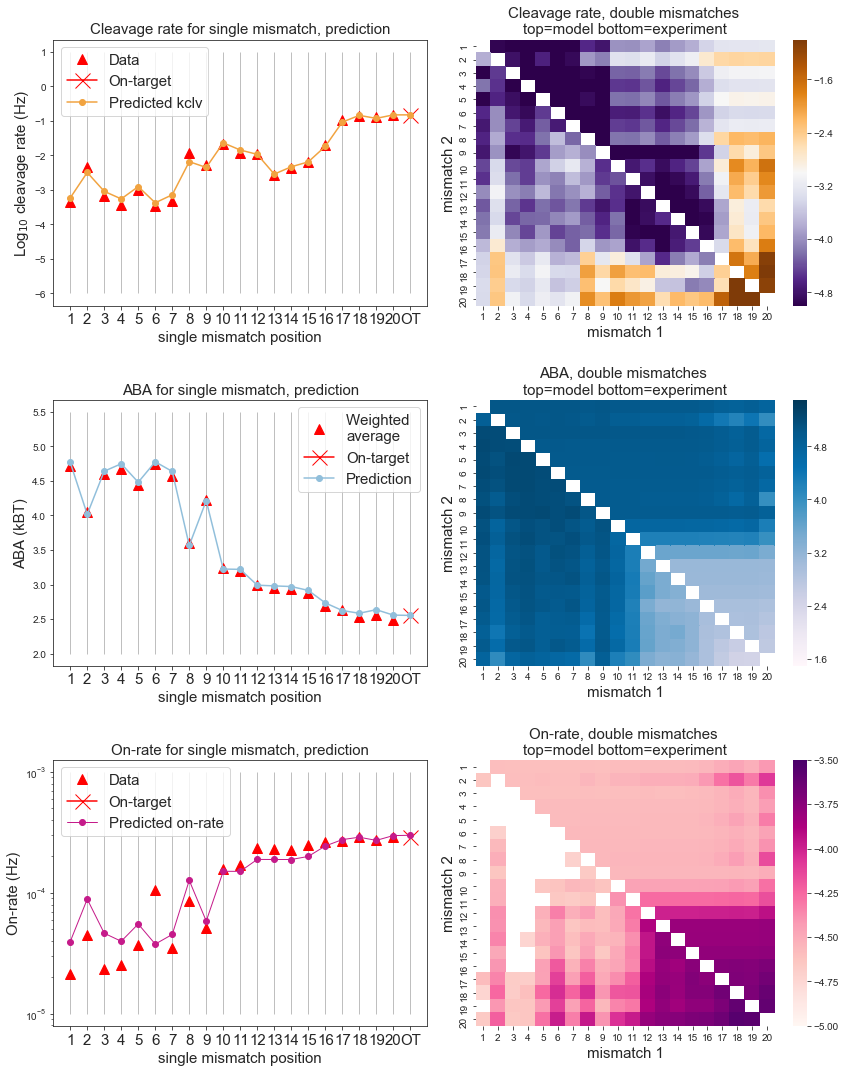

In [38]:
legend = True

f,ax = plt.subplots(3,2,sharey=False,figsize=[12,15])

k = np.zeros(21)
on = np.zeros(21)
abafit = np.zeros(21)

#conc = np.array([1.,30.,100.])
conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair
otaba = clv.calc_ABA(parameters_on,conc,ref,[],model_ID_on)

for i in range(1,guide+1):
    mismatch = [i]
    k[i-1],on[i-1] = clv.calc_clv_on(final_par_np_on,model_ID,mismatch,guide)
    _,abafit[i-1] = clv.calc_clv_aba(final_par_np,model_ID,mismatch,guide,conc,ref)
    
k[-1],on[-1] = clv.calc_clv_on(final_par_np_on,model_ID,[],guide)
abafit[-1] = otaba

plot2 = ax[0][0].plot(range(1,21),kclv[0:20],marker='^',linewidth=0,markersize=10.,color='r',label='Data')
plot3 = ax[0][0].plot(21,kclv[20],marker='x',color='r',markersize=15,label='On-target')
plot4 = ax[0][0].plot(range(1,22),np.log10(k),color='#f1a340',marker='o',label='Predicted kclv')
if legend:
    ax[0][0].legend(handles=[plot2[0],plot3[0],plot4[0]],fontsize=15)
ax[0][0].set_xlabel('single mismatch position', fontsize=15)
ax[0][0].set_ylabel('Log$_{10}$ cleavage rate (Hz)', fontsize=15)
ax[0][0].set_title('Cleavage rate for single mismatch, prediction', fontsize=15)
ax[0][0].set_xticks(range(1,22));
ax[0][0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
ax[0][0].vlines(range(1,22),-6,1,color='grey',linewidth=0.5);

plot2 = ax[2][0].plot(range(1,21),kon[0:20],marker='^',linewidth=0,markersize=10.,color='r',label='Data')
plot3 = ax[2][0].plot(21,kon[20],marker='x',color='r',markersize=15,label='On-target')
plot4 = ax[2][0].semilogy(range(1,22),on,marker='o',linewidth=1,color='#c51b8a',label='Predicted on-rate')
if legend:
    ax[2][0].legend(handles=[plot2[0],plot3[0],plot4[0]],fontsize=15)
ax[2][0].set_xlabel('single mismatch position', fontsize=15)
ax[2][0].set_ylabel('On-rate (Hz)', fontsize=15)
ax[2][0].set_title('On-rate for single mismatch, prediction', fontsize=15)
ax[2][0].set_xticks(range(1,22));
ax[2][0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
ax[2][0].vlines(range(1,22),10**-5.,10**-3.,color='grey',linewidth=0.5);

plot2, = ax[1][0].plot(range(1,21),aba[:-1],marker='^',linewidth=0,markersize=10.,color='r',label='Weighted \naverage')
plot3, = ax[1][0].plot(21,aba[-1],marker='x',color='r',markersize=15,label='On-target')
plot4, = ax[1][0].plot(range(1,22),abafit,marker='o',color='#91bfdb',label='Prediction')
if legend:
    ax[1][0].legend(handles=[plot2,plot3,plot4],fontsize=15)
ax[1][0].set_xlabel('single mismatch position', fontsize=15)
ax[1][0].set_ylabel('ABA (kBT)', fontsize=15)
ax[1][0].set_title('ABA for single mismatch, prediction', fontsize=15)
ax[1][0].set_xticks(range(1,22));
ax[1][0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
ax[1][0].vlines(range(1,22),2.,5.5,color='grey',linewidth=0.5);

k_matrix = np.zeros([20,20])
on_matrix = np.zeros([20,20])
aba_matrix = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix[i-1,j-1], on_matrix[i-1,j-1] = np.log10(clv.calc_clv_on(final_par_np_on,model_ID,mismatch_positions,guide))
        _, aba_matrix[i-1,j-1] = clv.calc_clv_aba(final_par_np,model_ID,mismatch_positions,guide,conc,ref)
        
        
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))
on_df = pd.DataFrame(on_matrix, index=range(1,21), columns=range(1,21))
aba_df = pd.DataFrame(aba_matrix, index=range(1,21), columns=range(1,21))

combined_df_wa = k_df + k_double_df
combined_on = on_df + on_double_df
combined_aba = aba_df + aba_double_df

for i in range(1,21):
    combined_df_wa[i].loc[i]= np.nan
    combined_on[i].loc[i] = np.nan
    combined_aba[i].loc[i] = np.nan

sns.heatmap(combined_df_wa, cmap='PuOr_r', cbar=True,ax=ax[0][1], vmin=-5, vmax = -1)
ax[0][1].set_xlabel('mismatch 1', fontsize=15)
ax[0][1].set_ylabel('mismatch 2', fontsize=15)
ax[0][1].set_title('Cleavage rate, double mismatches \ntop=model bottom=experiment', fontsize=15)

sns.heatmap(combined_on,cmap='RdPu', cbar=True,ax=ax[2][1], vmin = -5, vmax = -3.5)
ax[2][1].set_xlabel('mismatch 1', fontsize=15)
ax[2][1].set_ylabel('mismatch 2', fontsize=15)
ax[2][1].set_title('On-rate, double mismatches \ntop=model bottom=experiment', fontsize=15)

sns.heatmap(combined_aba,cmap='PuBu', cbar=True,ax=ax[1][1], vmin = 1.5, vmax = 5.5)
ax[1][1].set_xlabel('mismatch 1', fontsize=15)
ax[1][1].set_ylabel('mismatch 2', fontsize=15)
ax[1][1].set_title('\nABA, double mismatches \ntop=model bottom=experiment', fontsize=15)

plt.tight_layout()

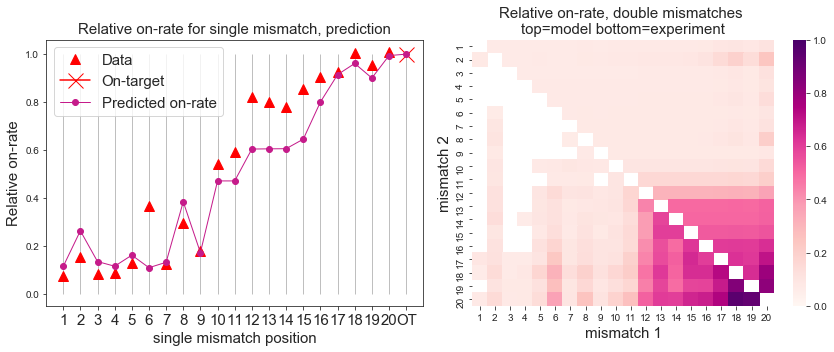

In [49]:
legend = True

f,ax = plt.subplots(1,2,sharey=False,figsize=[12,5])

on = np.zeros(21)

for i in range(1,guide+1):
    mismatch = [i]
    _,on[i-1] = clv.calc_clv_on(final_par_np,model_ID,mismatch,guide)
    
_,on[-1] = clv.calc_clv_on(final_par_np,model_ID,[],guide)

on_r = on/on[-1]
kon_r = kon/kon[-1]


plot2 = ax[0].plot(range(1,21),kon_r[0:20],marker='^',linewidth=0,markersize=10.,color='r',label='Data')
plot3 = ax[0].plot(21,kon_r[20],marker='x',color='r',markersize=15,label='On-target')
plot4 = ax[0].plot(range(1,22),on_r,marker='o',linewidth=1,color='#c51b8a',label='Predicted on-rate')
if legend:
    ax[0].legend(handles=[plot2[0],plot3[0],plot4[0]],fontsize=15)
ax[0].set_xlabel('single mismatch position', fontsize=15)
ax[0].set_ylabel('Relative on-rate', fontsize=15)
ax[0].set_title('Relative on-rate for single mismatch, prediction', fontsize=15)
ax[0].set_xticks(range(1,22));
ax[0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
ax[0].vlines(range(1,22),0,1,color='grey',linewidth=0.5);

on_matrix = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        _, on_matrix[i-1,j-1] = (clv.calc_clv_on(final_par_np,model_ID,mismatch_positions,guide))/on[-1]
      
on_df = pd.DataFrame(on_matrix, index=range(1,21), columns=range(1,21))

combined_on = on_df + on_r_double_df

for i in range(1,21):
    combined_on[i].loc[i] = np.nan

sns.heatmap(combined_on,cmap='RdPu', cbar=True,ax=ax[1], vmin = 0, vmax = 1)
ax[1].set_xlabel('mismatch 1', fontsize=15)
ax[1].set_ylabel('mismatch 2', fontsize=15)
ax[1].set_title('Relative on-rate, double mismatches \ntop=model bottom=experiment', fontsize=15)

plt.tight_layout()